<a href="https://colab.research.google.com/github/mirpouya/TensorFlow-Tutorial/blob/main/Human_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1

import cv2

In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [3]:
train_directory = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test"

In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pouyammsadeghi","key":"773ac957be00991204924caaf65a4f47"}'}

In [6]:
 ! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 97% 299M/309M [00:02<00:00, 105MB/s]
100% 309M/309M [00:02<00:00, 127MB/s]


In [ ]:
! mkdir human-emotions-datasethes
! unzip human-emotions-datasethes.zip -d human-emotions-datasethes

In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='int',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [13]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='int',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


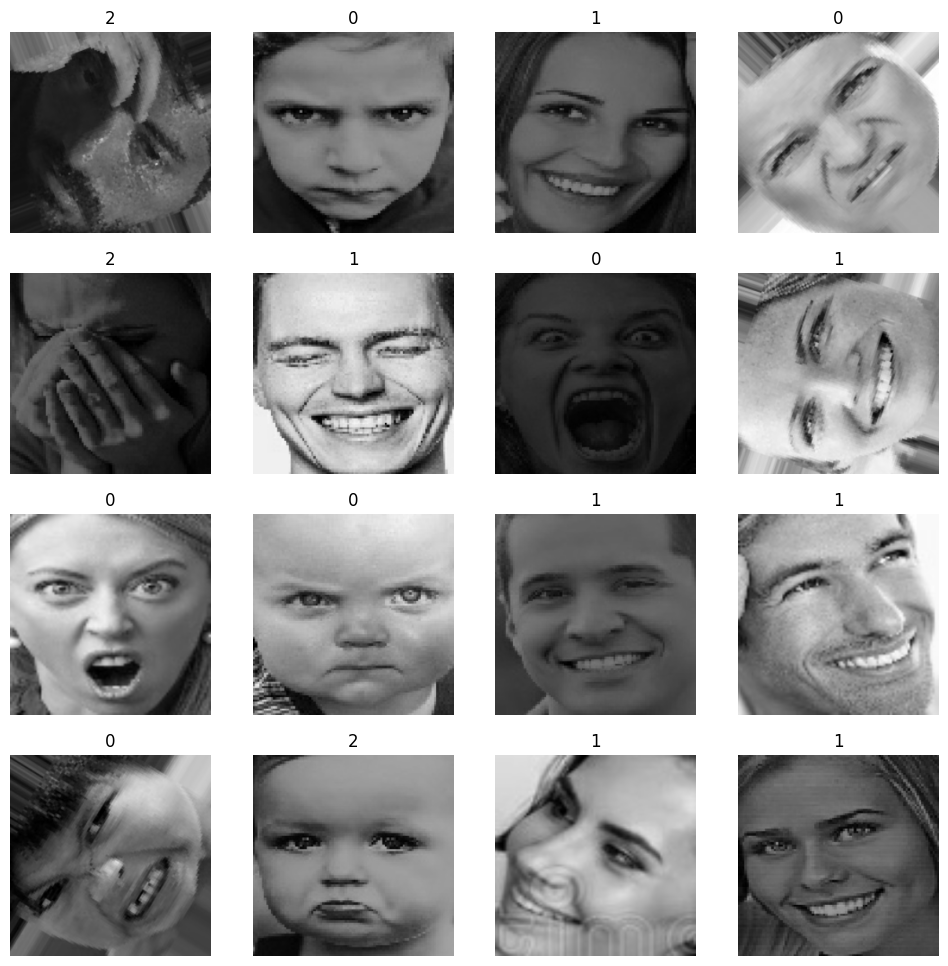

In [14]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title((labels[i]).numpy())
    plt.axis("off")

In [15]:
training_dataset = (
    train_dataset.prefetch(tf.data.AUTOTUNE)
)

In [16]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [17]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255)
])

In [18]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
lenet_model_1 = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [21]:
#loss_function = CategoricalCrossentropy()
loss_function = SparseCategoricalCrossentropy()

In [22]:
metrics = [SparseCategoricalAccuracy()]

In [23]:
lenet_model_1.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [24]:
history = lenet_model_1.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  #epochs = 5,
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20
213/213 [==============================] - 34s 116ms/step - loss: 0.9390 - sparse_categorical_accuracy: 0.5752 - val_loss: 1.0998 - val_sparse_categorical_accuracy: 0.4096
Epoch 2/20
213/213 [==============================] - 20s 94ms/step - loss: 0.6089 - sparse_categorical_accuracy: 0.7472 - val_loss: 1.0414 - val_sparse_categorical_accuracy: 0.6014
Epoch 3/20
213/213 [==============================] - 21s 95ms/step - loss: 0.3997 - sparse_categorical_accuracy: 0.8526 - val_loss: 1.2039 - val_sparse_categorical_accuracy: 0.5518
Epoch 4/20
213/213 [==============================] - 21s 99ms/step - loss: 0.2504 - sparse_categorical_accuracy: 0.9085 - val_loss: 1.3638 - val_sparse_categorical_accuracy: 0.4794
Epoch 5/20
213/213 [==============================] - 20s 95ms/step - loss: 0.2753 - sparse_categorical_accuracy: 0.9016 - val_loss: 1.0758 - val_sparse_categorical_accuracy: 0.6203
Epoch 6/20
213/213 [==============================] - 21s 98ms/step - loss: 0.1627 - spar

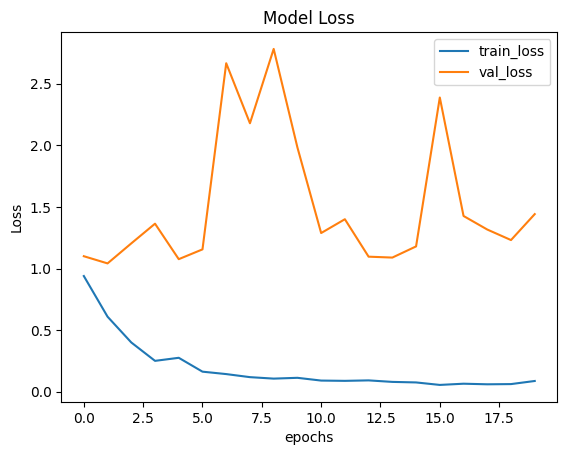

In [25]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend(["train_loss", "val_loss"])
plt.show()

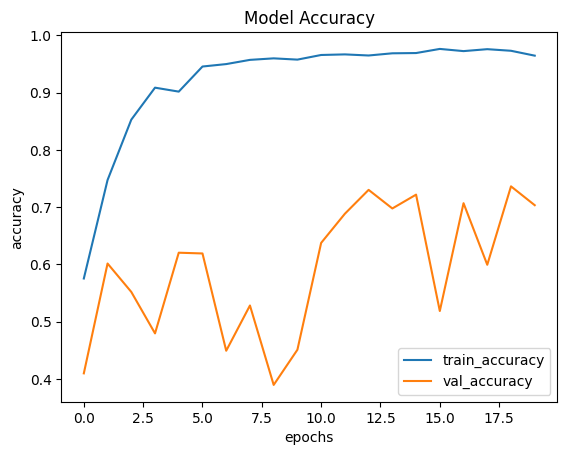

In [26]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

<b> <h2> Evaluation </h2> <b>

In [27]:
lenet_model_1.evaluate(validation_dataset)

2278/2278 [==============================] - 10s 4ms/step - loss: 1.4415 - sparse_categorical_accuracy: 0.7032


[1.4415407180786133, 0.7032484412193298]

In [28]:
# evaluating on train data

lenet_model_1.evaluate(training_dataset)

213/213 [==============================] - 11s 49ms/step - loss: 0.1932 - sparse_categorical_accuracy: 0.9293


[0.19324402511119843, 0.9292542934417725]

<b> The model is overfitting </b>

<b> <h2> Testing </h2> </b>

In [29]:
test_image = cv2.imread("/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train/sad/10416.jpg_brightness_1.jpg")

In [30]:
im = tf.constant(test_image, dtype=tf.float32)

In [31]:
print(im.shape)

(224, 224, 3)


In [32]:
im = tf.expand_dims(im, axis=0)
print(im.shape)

(1, 224, 224, 3)


In [33]:
lenet_model_1(im)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[7.2203972e-04, 1.9660744e-01, 8.0267048e-01]], dtype=float32)>

In [43]:
print(CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model_1(im), axis=-1).numpy()[0]])

sad
